In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [3]:
USE_CUDA = torch.cuda.is_available() and False 
device = torch.device('cuda' if USE_CUDA else 'cpu')

### data load

In [4]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

### DeepLab v3 ResNet50 

In [5]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [7]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [8]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [9]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

In [10]:
len(classLabels), len(validClasses), classLabels[0], validClasses[0]

(12, 12, 'Pole', 0)

### train

In [11]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

In [12]:
dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

In [13]:
weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

In [14]:
class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

In [15]:
num_epoch = 15
res = train_X.shape[1] * train_X.shape[2]

In [16]:
for epoch in range(num_epoch):

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))
    
    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        
        model.train()    
    
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
        # progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save path
    if not os.path.isdir(os.getcwd() + '/result'):
        os.makedirs(os.getcwd() + '/result')
    
    save_path = os.getcwd() + '/result/'
    
    with open(save_path + '04_resnet101_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, save_path + now_time + '_best_weights.pth.tar')


100%|██████████| 56/56 [1:25:40<00:00, 91.80s/it]


classes           IoU
---------------------
Pole          : 0.075
SignSymbol    : 0.214
Bicyclist     : 0.319
Pedestrian    : 0.252
Building      : 0.507
Fence         : 0.210
Pavement      : 0.501
Road          : 0.775
Car           : 0.604
Sky           : 0.688
Tree          : 0.543
---------------------
Mean IoU      : 0.426
---------------------
train epoch  1
loss : 0.9986   acc : 0.7014   miou : 0.4261


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.0000 to 0.4261.


100%|██████████| 56/56 [1:25:46<00:00, 91.90s/it]


classes           IoU
---------------------
Pole          : 0.210
SignSymbol    : 0.464
Bicyclist     : 0.610
Pedestrian    : 0.550
Building      : 0.745
Fence         : 0.513
Pavement      : 0.717
Road          : 0.918
Car           : 0.847
Sky           : 0.875
Tree          : 0.757
---------------------
Mean IoU      : 0.655
---------------------
train epoch  2
loss : 0.4404   acc : 0.8607   miou : 0.6551


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.4261 to 0.6551.


100%|██████████| 56/56 [1:25:49<00:00, 91.95s/it]


classes           IoU
---------------------
Pole          : 0.264
SignSymbol    : 0.506
Bicyclist     : 0.669
Pedestrian    : 0.588
Building      : 0.791
Fence         : 0.635
Pavement      : 0.759
Road          : 0.933
Car           : 0.868
Sky           : 0.887
Tree          : 0.784
---------------------
Mean IoU      : 0.698
---------------------
train epoch  3
loss : 0.3599   acc : 0.8831   miou : 0.6985


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.6551 to 0.6985.


100%|██████████| 56/56 [1:25:43<00:00, 91.85s/it]


classes           IoU
---------------------
Pole          : 0.318
SignSymbol    : 0.557
Bicyclist     : 0.718
Pedestrian    : 0.616
Building      : 0.816
Fence         : 0.682
Pavement      : 0.796
Road          : 0.943
Car           : 0.883
Sky           : 0.895
Tree          : 0.799
---------------------
Mean IoU      : 0.729
---------------------
train epoch  4
loss : 0.3025   acc : 0.8969   miou : 0.7294


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.6985 to 0.7294.


100%|██████████| 56/56 [1:25:43<00:00, 91.85s/it]


classes           IoU
---------------------
Pole          : 0.346
SignSymbol    : 0.595
Bicyclist     : 0.733
Pedestrian    : 0.638
Building      : 0.838
Fence         : 0.721
Pavement      : 0.819
Road          : 0.950
Car           : 0.890
Sky           : 0.899
Tree          : 0.811
---------------------
Mean IoU      : 0.749
---------------------
train epoch  5
loss : 0.2638   acc : 0.9075   miou : 0.7490


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7294 to 0.7490.


100%|██████████| 56/56 [1:25:50<00:00, 91.97s/it]


classes           IoU
---------------------
Pole          : 0.369
SignSymbol    : 0.622
Bicyclist     : 0.746
Pedestrian    : 0.648
Building      : 0.854
Fence         : 0.770
Pavement      : 0.840
Road          : 0.956
Car           : 0.895
Sky           : 0.903
Tree          : 0.823
---------------------
Mean IoU      : 0.766
---------------------
train epoch  6
loss : 0.2378   acc : 0.9158   miou : 0.7661


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7490 to 0.7661.


100%|██████████| 56/56 [1:25:53<00:00, 92.03s/it]


classes           IoU
---------------------
Pole          : 0.389
SignSymbol    : 0.647
Bicyclist     : 0.762
Pedestrian    : 0.660
Building      : 0.866
Fence         : 0.788
Pavement      : 0.845
Road          : 0.958
Car           : 0.899
Sky           : 0.907
Tree          : 0.834
---------------------
Mean IoU      : 0.778
---------------------
train epoch  7
loss : 0.2198   acc : 0.9213   miou : 0.7778


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7661 to 0.7778.


100%|██████████| 56/56 [1:25:48<00:00, 91.94s/it]


classes           IoU
---------------------
Pole          : 0.403
SignSymbol    : 0.661
Bicyclist     : 0.765
Pedestrian    : 0.669
Building      : 0.872
Fence         : 0.805
Pavement      : 0.857
Road          : 0.962
Car           : 0.904
Sky           : 0.907
Tree          : 0.839
---------------------
Mean IoU      : 0.786
---------------------
train epoch  8
loss : 0.2056   acc : 0.9251   miou : 0.7857


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7778 to 0.7857.


100%|██████████| 56/56 [1:25:45<00:00, 91.89s/it]


classes           IoU
---------------------
Pole          : 0.416
SignSymbol    : 0.676
Bicyclist     : 0.778
Pedestrian    : 0.673
Building      : 0.878
Fence         : 0.804
Pavement      : 0.860
Road          : 0.962
Car           : 0.905
Sky           : 0.912
Tree          : 0.847
---------------------
Mean IoU      : 0.792
---------------------
train epoch  9
loss : 0.1954   acc : 0.9281   miou : 0.7918


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7857 to 0.7918.


100%|██████████| 56/56 [1:25:42<00:00, 91.84s/it]


classes           IoU
---------------------
Pole          : 0.427
SignSymbol    : 0.689
Bicyclist     : 0.784
Pedestrian    : 0.680
Building      : 0.882
Fence         : 0.813
Pavement      : 0.866
Road          : 0.965
Car           : 0.910
Sky           : 0.911
Tree          : 0.849
---------------------
Mean IoU      : 0.798
---------------------
train epoch  10
loss : 0.1869   acc : 0.9302   miou : 0.7978


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7918 to 0.7978.


100%|██████████| 56/56 [1:25:47<00:00, 91.92s/it]


classes           IoU
---------------------
Pole          : 0.441
SignSymbol    : 0.701
Bicyclist     : 0.787
Pedestrian    : 0.689
Building      : 0.890
Fence         : 0.830
Pavement      : 0.875
Road          : 0.967
Car           : 0.912
Sky           : 0.912
Tree          : 0.854
---------------------
Mean IoU      : 0.805
---------------------
train epoch  11
loss : 0.1767   acc : 0.9337   miou : 0.8054


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.7978 to 0.8054.


100%|██████████| 56/56 [1:25:51<00:00, 91.99s/it]


classes           IoU
---------------------
Pole          : 0.449
SignSymbol    : 0.710
Bicyclist     : 0.792
Pedestrian    : 0.695
Building      : 0.893
Fence         : 0.834
Pavement      : 0.879
Road          : 0.968
Car           : 0.912
Sky           : 0.915
Tree          : 0.859
---------------------
Mean IoU      : 0.810
---------------------
train epoch  12
loss : 0.1700   acc : 0.9358   miou : 0.8096


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.8054 to 0.8096.


100%|██████████| 56/56 [1:25:49<00:00, 91.95s/it]


classes           IoU
---------------------
Pole          : 0.458
SignSymbol    : 0.718
Bicyclist     : 0.791
Pedestrian    : 0.702
Building      : 0.897
Fence         : 0.841
Pavement      : 0.882
Road          : 0.968
Car           : 0.915
Sky           : 0.916
Tree          : 0.865
---------------------
Mean IoU      : 0.814
---------------------
train epoch  13
loss : 0.1625   acc : 0.9377   miou : 0.8140


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.8096 to 0.8140.


100%|██████████| 56/56 [1:25:45<00:00, 91.88s/it]


classes           IoU
---------------------
Pole          : 0.465
SignSymbol    : 0.723
Bicyclist     : 0.801
Pedestrian    : 0.703
Building      : 0.900
Fence         : 0.853
Pavement      : 0.884
Road          : 0.969
Car           : 0.917
Sky           : 0.917
Tree          : 0.868
---------------------
Mean IoU      : 0.818
---------------------
train epoch  14
loss : 0.1577   acc : 0.9393   miou : 0.8182


  0%|          | 0/56 [00:00<?, ?it/s]

mIoU improved from 0.8140 to 0.8182.


100%|██████████| 56/56 [1:25:42<00:00, 91.83s/it]


classes           IoU
---------------------
Pole          : 0.472
SignSymbol    : 0.736
Bicyclist     : 0.804
Pedestrian    : 0.709
Building      : 0.904
Fence         : 0.852
Pavement      : 0.887
Road          : 0.969
Car           : 0.918
Sky           : 0.919
Tree          : 0.870
---------------------
Mean IoU      : 0.822
---------------------
train epoch  15
loss : 0.1541   acc : 0.9406   miou : 0.8217
mIoU improved from 0.8182 to 0.8217.


### test

In [18]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=4, shuffle=True)

In [19]:
# Load best model

# save path
if not os.path.isdir(os.getcwd() + '/result'):
    os.makedirs(os.getcwd() + '/result')

save_path = os.getcwd() + '/result/'
result = sorted(os.listdir(save_path), reverse=True)

In [20]:
checkpoint = torch.load(save_path + result[1]) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], save_path + result[1]))

Loaded best model weights (epoch 14) from /home/ag/Capstone2/TEST/result/210604_14:46_best_weights.pth.tar


In [21]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')  
iou = iouCalc(classLabels, validClasses, voidClass = 11)
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 36/36 [10:03<00:00, 16.77s/it]

classes           IoU
---------------------
Pole          : 0.374
SignSymbol    : 0.552
Bicyclist     : 0.777
Pedestrian    : 0.673
Building      : 0.891
Fence         : 0.739
Pavement      : 0.826
Road          : 0.959
Car           : 0.892
Sky           : 0.927
Tree          : 0.830
---------------------
Mean IoU      : 0.767
---------------------
loss : 0.3698 acc : 0.9222 miou : 0.7671



/home/ag/Capstone2/venv_cap/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


### visualization

In [2]:
import pandas as pd
log_epoch = pd.read_csv('result/04_resnet101_log_epoch.csv',
                       names = ['epoch', 'loss', 'accuracy', 'miou'])

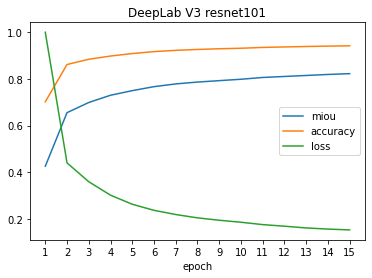

In [3]:
import matplotlib.pyplot as plt
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet101")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

In [33]:
train_X = torch.tensor(train_x[:int(train_x.shape[0]*0.875)], dtype=torch.float32)
train_Y = torch.tensor(train_y[:int(train_y.shape[0]*0.875)], dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [ ]:
val_X = torch.tensor(train_x[int(train_x.shape[0]*0.875):], dtype=torch.float32)
val_Y = torch.tensor(train_y[int(train_x.shape[0]*0.875):], dtype=torch.long)

val_data = torch.utils.data.TensorDataset(val_X.permute(dims=(0, 3, 1, 2)), val_Y)

val_data = torch.utils.data.DataLoader(val_data, batch_size=2, shuffle=False)

In [ ]:
# validataion
model.eval()

loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')
iou = iouCalc(classLabels, validClasses, voidClass = 11)

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(val_data, total=len(val_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()

# Reduce learning rate
scheduler.step(loss_running.avg) 

print('validataion')
print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))